<a href="https://colab.research.google.com/github/soobook/PyTorch-DL/blob/main/code/PT10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10회차: CNN을 활용한 컬러 이미지 분류 (4) – 모델 최적화

## 고도화된 CNN 모델 구현

In [1]:
# PyTorch를 이용한 고도화된 CNN 모델 구현
# CIFAR-10 데이터셋을 기반으로 모델 성능 향상을 위해 다양한 기법을 적용한 예제

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
# 이미지 전처리와 데이터 증강(Data Augmentation) 을 위한 모듈
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
# 데이터셋 샘플링 시 각 데이터에 다른 확률을 부여해서 뽑을 수 있게 하는 샘플러
from torch.utils.data import WeightedRandomSampler
from collections import Counter

In [2]:
# ================================
# 1. 데이터 전처리 및 증강
# ================================

# 학습 데이터에 다양한 데이터 증강 기법을 적용해 모델의 일반화 성능을 향상
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),            # 이미지를 좌우로 무작위 반전
    transforms.RandomCrop(32, padding=4),         # 4픽셀 패딩 후 32x32 크기로 무작위 크롭
    transforms.ColorJitter(brightness=0.2,        # 밝기 조절
                           contrast=0.2,          # 대비 조절
                           saturation=0.2),       # 채도 조절
    transforms.RandomRotation(10),                # -10도~+10도 범위에서 무작위 회전
    transforms.ToTensor(),                        # PIL 이미지를 Tensor로 변환
    transforms.Normalize((0.4914, 0.4822, 0.4465), # 각 채널별 평균과 표준편차로 정규화
                         (0.2023, 0.1994, 0.2010))
])

# 테스트 데이터는 데이터 증강 없이 정규화만 수행
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# CIFAR-10 학습/테스트 데이터셋 로드
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

100%|██████████| 170M/170M [00:03<00:00, 43.2MB/s]


In [4]:
# ================================
# 2. CNN 모델 정의
# ================================

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()

        # 특징 추출을 위한 Convolutional Layer 블록 정의
        self.features = nn.Sequential(
            # 첫 번째 블록: 3채널 입력 → 64채널 출력
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),

            # 두 번째 블록: 64채널 → 128채널
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),

            # 세 번째 블록: 128채널 → 256채널
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.3)
        )

        # 전결합층 (Flatten 후 Classifier)
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),  # Conv 결과를 FC 입력으로 변환
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)           # CIFAR-10 클래스 수만큼 출력
        )

    def forward(self, x):
        x = self.features(x)              # Conv 레이어 통과
        x = x.view(x.size(0), -1)         # Flatten
        x = self.classifier(x)            # Fully connected layer 통과
        return x

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = ImprovedCNN().to(device)  # 모델을 GPU 또는 CPU로 이동
summary(net, (3, 32, 32))       # 모델 구조 요약 출력

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
           Dropout-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

In [11]:
# ================================
# 3. 학습 준비
# ================================

criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류용 손실 함수
optimizer = optim.AdamW(net.parameters(), lr=0.001)  # Adam의 정규화 강화 버전
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

## 클래스 불균형(class imbalance) 문제 해결

In [8]:
# ================================
#  데이터 불균형 처리
# ================================

# 클래스별 샘플 수 세기 → 불균형 데이터 대응용
targets = trainset.targets
class_count = Counter(targets)  # {클래스: 샘플 수}
print(class_count)
class_weights = [1.0 / class_count[i] for i in targets]  # 빈도에 반비례한 가중치 생성
print(class_weights[:10]) # 모두 1/5000 = 0.0002 동일

Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})
[0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002]


In [9]:
# 데이터를 고르게 샘플링하는 전략 설정
sampler = WeightedRandomSampler(class_weights, num_samples=len(class_weights), replacement=True)

# WeightedRandomSampler를 이용한 불균형 보정 학습 데이터로더 생성
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, sampler=sampler, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = trainset.classes  # CIFAR-10 클래스 라벨 (예: 'airplane', 'car', ...)
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [12]:
# ================================
# 4. 학습 루프
# ================================

epochs = 30
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    net.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()          # 이전 gradient 초기화
        outputs = net(inputs)          # 순전파
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()               # 역전파
        optimizer.step()              # 파라미터 갱신

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)

    # 테스트 정확도 평가
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    scheduler.step(avg_loss)

    print(f'[Epoch {epoch+1:2d}] Loss: {avg_loss:.3f} | Accuracy: {accuracy:.2f}%')

[Epoch  1] Loss: 1.810 | Accuracy: 50.20%
[Epoch  2] Loss: 1.420 | Accuracy: 55.95%
[Epoch  3] Loss: 1.272 | Accuracy: 62.73%
[Epoch  4] Loss: 1.177 | Accuracy: 66.83%
[Epoch  5] Loss: 1.118 | Accuracy: 67.66%
[Epoch  6] Loss: 1.062 | Accuracy: 70.34%
[Epoch  7] Loss: 1.004 | Accuracy: 73.79%
[Epoch  8] Loss: 0.952 | Accuracy: 73.43%
[Epoch  9] Loss: 0.925 | Accuracy: 75.60%
[Epoch 10] Loss: 0.896 | Accuracy: 77.19%
[Epoch 11] Loss: 0.859 | Accuracy: 77.75%
[Epoch 12] Loss: 0.828 | Accuracy: 78.60%
[Epoch 13] Loss: 0.808 | Accuracy: 79.95%
[Epoch 14] Loss: 0.787 | Accuracy: 80.85%
[Epoch 15] Loss: 0.759 | Accuracy: 81.59%
[Epoch 16] Loss: 0.743 | Accuracy: 80.96%
[Epoch 17] Loss: 0.720 | Accuracy: 81.35%
[Epoch 18] Loss: 0.702 | Accuracy: 82.13%
[Epoch 19] Loss: 0.679 | Accuracy: 81.86%
[Epoch 20] Loss: 0.664 | Accuracy: 82.87%
[Epoch 21] Loss: 0.654 | Accuracy: 83.08%
[Epoch 22] Loss: 0.635 | Accuracy: 82.31%
[Epoch 23] Loss: 0.622 | Accuracy: 84.83%
[Epoch 24] Loss: 0.614 | Accuracy:

In [13]:
%config InlineBackend.figure_format = 'retina'

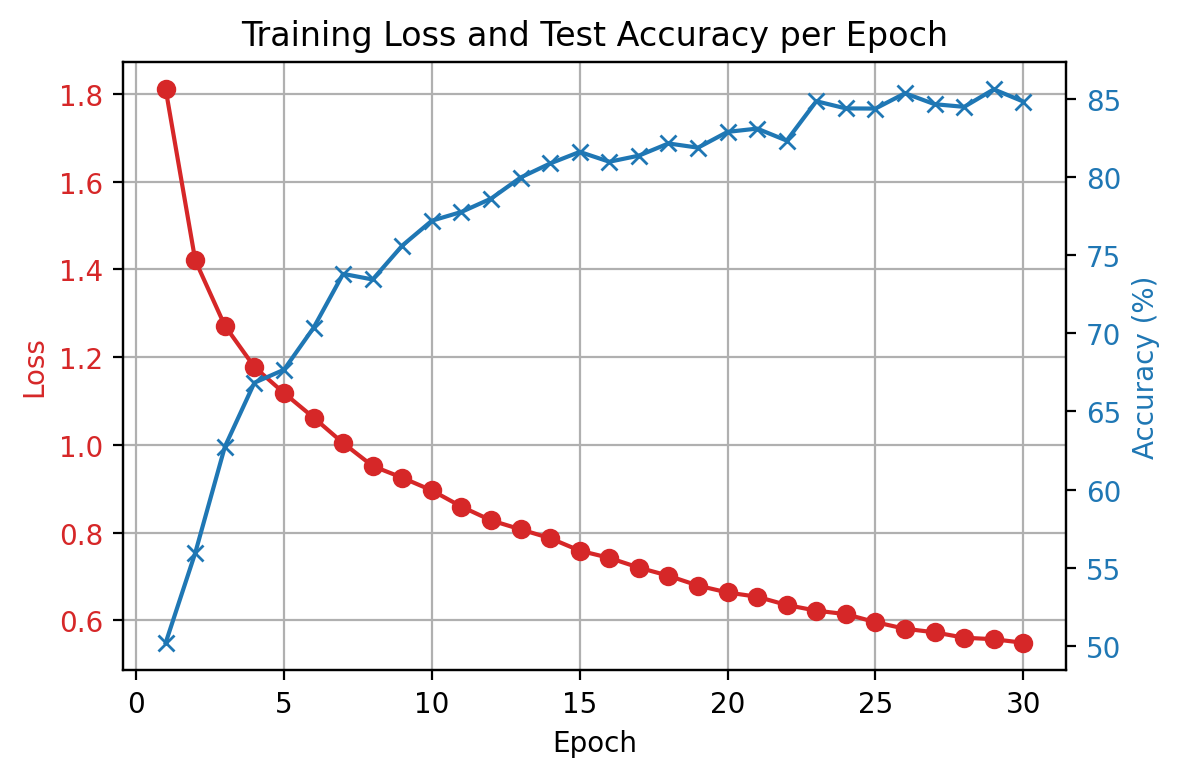

In [14]:
# matplotlib 라이브러리에서 그래프를 그리기 위한 pyplot 모듈 임포트
import matplotlib.pyplot as plt

# 손실과 정확도를 함께 시각화하는 함수 정의
def plot_loss_and_accuracy_together(train_losses, test_accuracies):
    # 에폭 번호 리스트 생성 (1부터 시작)
    epochs = range(1, len(train_losses) + 1)

    # 하나의 figure와 기본 축(ax1)을 생성 (그래프 크기는 6x4인치)
    fig, ax1 = plt.subplots(figsize=(6, 4))

    # === 왼쪽 Y축: 손실(Loss) ===
    color = 'tab:red'  # 손실 곡선은 빨간색으로
    ax1.set_xlabel('Epoch')  # X축 라벨: 에폭 번호
    ax1.set_ylabel('Loss', color=color)  # 왼쪽 Y축 라벨: 손실값
    ax1.plot(epochs, train_losses, color=color, marker='o', label='Loss')  # 손실 곡선 그리기 (동그라미 마커 사용)
    ax1.tick_params(axis='y', labelcolor=color)  # 왼쪽 Y축 눈금 색상도 빨간색으로
    ax1.grid(True)  # 배경에 그리드 표시 (보기 편하게)

    # === 오른쪽 Y축: 정확도(Accuracy) ===
    ax2 = ax1.twinx()  # ax1과 X축을 공유하는 새로운 Y축 생성
    color = 'tab:blue'  # 정확도 곡선은 파란색으로
    ax2.set_ylabel('Accuracy (%)', color=color)  # 오른쪽 Y축 라벨
    ax2.plot(epochs, test_accuracies, color=color, marker='x', label='Accuracy')  # 정확도 곡선 그리기 (X 마커 사용)
    ax2.tick_params(axis='y', labelcolor=color)  # 오른쪽 Y축 눈금 색상 파란색

    # 전체 그래프 제목 설정
    plt.title('Training Loss and Test Accuracy per Epoch')

    # 레이아웃 자동 조정 (레이블 겹침 방지)
    fig.tight_layout()

    # 최종 그래프 화면에 출력
    plt.show()

# 함수 호출: 손실과 정확도 그래프 그리기
plot_loss_and_accuracy_together(train_losses, test_accuracies)

- GPU 사용: 약 20분 소요
- CPU 사용: 약 4~5시간 소요

## 10회차 전체 코드

In [ ]:
# PyTorch를 이용한 고도화된 CNN 모델 구현
# CIFAR-10 데이터셋을 기반으로 모델 성능 향상을 위해 다양한 기법을 적용한 예제

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from torch.utils.data import WeightedRandomSampler
from collections import Counter

# ================================
# 1. 데이터 전처리 및 증강
# ================================

# 학습 데이터에 다양한 데이터 증강 기법을 적용해 모델의 일반화 성능을 향상
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),            # 이미지를 좌우로 무작위 반전
    transforms.RandomCrop(32, padding=4),         # 4픽셀 패딩 후 32x32 크기로 무작위 크롭
    transforms.ColorJitter(brightness=0.2,        # 밝기 조절
                           contrast=0.2,          # 대비 조절
                           saturation=0.2),       # 채도 조절
    transforms.RandomRotation(10),                # -10도~+10도 범위에서 무작위 회전
    transforms.ToTensor(),                        # PIL 이미지를 Tensor로 변환
    transforms.Normalize((0.4914, 0.4822, 0.4465), # 각 채널별 평균과 표준편차로 정규화
                         (0.2023, 0.1994, 0.2010))
])

# 테스트 데이터는 데이터 증강 없이 정규화만 수행
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# CIFAR-10 학습/테스트 데이터셋 로드
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# 클래스별 샘플 수 세기 → 불균형 데이터 대응용
targets = trainset.targets
class_count = Counter(targets)  # {클래스: 샘플 수}
class_weights = [1.0 / class_count[i] for i in targets]  # 빈도에 반비례한 가중치 생성
sampler = WeightedRandomSampler(class_weights, num_samples=len(class_weights), replacement=True)

# WeightedRandomSampler를 이용한 불균형 보정 학습 데이터로더 생성
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, sampler=sampler, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = trainset.classes  # CIFAR-10 클래스 라벨 (예: 'airplane', 'car', ...)

# ================================
# 2. CNN 모델 정의
# ================================

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()

        # 특징 추출을 위한 Convolutional Layer 블록 정의
        self.features = nn.Sequential(
            # 첫 번째 블록: 3채널 입력 → 64채널 출력
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),

            # 두 번째 블록: 64채널 → 128채널
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),

            # 세 번째 블록: 128채널 → 256채널
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.3)
        )

        # 전결합층 (Flatten 후 Classifier)
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),  # Conv 결과를 FC 입력으로 변환
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)           # CIFAR-10 클래스 수만큼 출력
        )

    def forward(self, x):
        x = self.features(x)              # Conv 레이어 통과
        x = x.view(x.size(0), -1)         # Flatten
        x = self.classifier(x)            # Fully connected layer 통과
        return x

# ================================
# 3. 학습 준비
# ================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = ImprovedCNN().to(device)  # 모델을 GPU 또는 CPU로 이동
summary(net, (3, 32, 32))       # 모델 구조 요약 출력

criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류용 손실 함수
optimizer = optim.AdamW(net.parameters(), lr=0.001)  # Adam의 L2 정규화 강화 버전
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

# ================================
# 4. 학습 루프
# ================================

epochs = 20
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    net.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()          # 이전 gradient 초기화
        outputs = net(inputs)          # 순전파
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()               # 역전파
        optimizer.step()              # 파라미터 갱신

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)

    # 테스트 정확도 평가
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    scheduler.step(avg_loss)

    print(f'[Epoch {epoch+1}] Loss: {avg_loss:.3f} | Accuracy: {accuracy:.2f}%')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
           Dropout-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

## 종료